# Data Analysis and Visualization of Time to Target with Tremor Identification

This code was developed to analyze data and generate figures for "Evaluating Mouse Control and Usability Patterns Across Tremor and Non-Tremor Populations"

### Loading necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Combining Mouse Time to Target and Tremor Data

In [2]:
# XY cursor targets for tasks
targets = pd.read_csv("./targets.csv")
targets = targets[['X', 'Y']]

# tremor status of participants
tremors = pd.read_csv('../survey analysis/survey_results_text.csv', skiprows=1, header=0)
tremors = tremors[tremors['participant_ID']!='SURVEY TEST']
tremors = tremors[['participant_ID', 'tremor_level']]

In [3]:
i = 1
cursor = pd.read_csv("./data/positions_" + str(i) + ".txt", sep='\t', header=None, names=['time', 'X', 'Y'])
clicks = cursor[cursor['time'] == 'Mouse Click'].index
clicks = cursor.loc[clicks-1]
clicks['time'] = pd.to_numeric(clicks['time'])
clicks['time_to_target'] = clicks['time'].diff()
clicks['participant_ID'] = 'PT' + str(i).zfill(2)

In [4]:
# Create dataframe with distance of mouse click from target in pixels
time_to_target = pd.DataFrame({'participant_ID': [], 'time_to_target': []})

for i in range(50):
    if os.path.exists("./data/positions_" + str(i) + ".txt"):

        # Identify Times of Clicks
        cursor = pd.read_csv("./data/positions_" + str(i) + ".txt", sep='\t', header=None, names=['time', 'X', 'Y'])
        clicks = cursor[cursor['time'] == 'Mouse Click'].index
        clicks = cursor.loc[clicks-1]
        clicks['time'] = pd.to_numeric(clicks['time'])

        clicks['time_to_target'] = clicks['time'].diff()       
        clicks['participant_ID'] = 'PT' + str(i).zfill(2)

        df = clicks[['participant_ID', 'time_to_target']]
        time_to_target = pd.concat([time_to_target, df], ignore_index=True)

# Merge the data
task_time = pd.merge(tremors, time_to_target, on='participant_ID')
task_time = task_time.dropna()

## Mixed-Effects Model of Task Click Accuracy

In [5]:
# Fit a linear mixed-effects model
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

model = smf.mixedlm("time_to_target ~ C(tremor_level)", data=task_time, groups=task_time["participant_ID"])
result = model.fit()
print(result.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    time_to_target
No. Observations:     960        Method:                REML          
No. Groups:           48         Scale:                 186.1800      
Min. group size:      20         Log-Likelihood:        -3909.2625    
Max. group size:      20         Converged:             Yes           
Mean group size:      20.0                                            
----------------------------------------------------------------------
                             Coef.  Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    12.524    1.287 9.734 0.000 10.002 15.046
C(tremor_level)[T.Sometimes]  1.855    3.226 0.575 0.565 -4.467  8.178
C(tremor_level)[T.Yes]       12.113    4.119 2.941 0.003  4.039 20.187
Group Var                    51.943    0.969                          



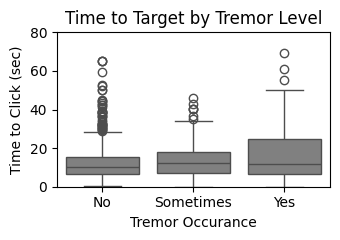

In [6]:
plt.figure(figsize=(3.5,2.5))

sns.boxplot(data=task_time, x='tremor_level', y='time_to_target', color='grey')
plt.ylim([0, 80])
plt.title('Time to Target by Tremor Level', fontsize=12)
plt.xlabel('Tremor Occurance')
plt.ylabel('Time to Click (sec)')
plt.tight_layout()
plt.savefig('time_to_target.png', dpi=300, bbox_inches='tight')

## Mean Click Accuracy per Participant

### Combine Data Into One DataFrame

In [7]:
mean_time = task_time.groupby(['participant_ID', 'tremor_level'], as_index=False)['time_to_target'].mean()

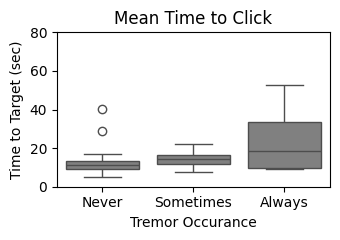

In [9]:
label_map = {
    'No': 'Never',
    'Sometimes': 'Sometimes',
    'Yes': 'Always'
}

plt.figure(figsize=(3.5,2.5))

mean_time['tremor_label'] = mean_time['tremor_level'].map(label_map)


sns.boxplot(data=mean_time, x='tremor_label', y='time_to_target', color='grey')
plt.ylim([0, 80])
plt.title('Mean Time to Click', fontsize=12)
plt.xlabel('Tremor Occurance')
plt.ylabel('Time to Target (sec)')
plt.tight_layout()
plt.savefig('time_to_target.png', dpi=300, bbox_inches='tight')

In [10]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# One-way ANOVA: Score by tremor_level
anova_model = ols('time_to_target ~ C(tremor_level)', data=mean_time).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)


                      sum_sq    df         F    PR(>F)
C(tremor_level)   532.341423   2.0  4.345475  0.018815
Residual         2756.357627  45.0       NaN       NaN


In [15]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run Tukey’s test
tukey = pairwise_tukeyhsd(endog=task_time['time_to_target'],
                          groups=task_time['tremor_level'],
                          alpha=0.05)

# Print summary table
print(tukey.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
       No Sometimes   1.8552 0.3882 -1.4614  5.1719  False
       No       Yes  12.1129    0.0  7.8775 16.3482   True
Sometimes       Yes  10.2576    0.0   5.214 15.3013   True
----------------------------------------------------------
